# Loading packages

In [1]:
%matplotlib inline
import numpy as np
import yaml
import matplotlib.pyplot as plt
import pandas as pd
import os

from clawpack.pyclaw.solution import Solution
from clawpack.pyclaw import solution
import matplotlib.animation
    
# Finding the home directory
from os.path import expanduser
home = expanduser("~")
cwd = os.getcwd()

user_directory = cwd

dirName = '_output'  #directory in which the results lie
dirAddress = user_directory+"/"+dirName
plt.rcParams['text.usetex'] = True
##########
#  AVAC  #
##########
from module_avac import check_claw, check_version 
from module_avac import flatten_dict
from module_avac import make_output 

# Computational parameters

In [2]:
xlower = -10.
xupper = 40
slope  = -np.deg2rad(10)
mx     = 10000

domain = {'xlower':xlower, 'xupper':xupper, 'mx':mx}
computation = {'left_boundary':'wall','right_boundary':'extrap','t_max':5,'nb_simul':100}
rheology = {'friction_forcing': False, 'Manning':0, 'gravity': 9.81, 'rho':1000, 'mu':0.0}

## Topography

In [4]:



def make_topo(xlower, xupper, mx, slope):
    x = np.linspace(xlower, xupper, mx+1)
    # topo
    def fnc_topo(x,slope):
        """
        inclined plane
        """
        z = np.tan(slope )*x
        return z
        
    z = fnc_topo(x,slope)
    # export
    fname='topography.data'

    with open(fname,'w') as f:
            f.write('%i   # number of points\n' % (mx+1))

            for i in range(mx+1):
                f.write('%15.8f %15.8f\n' % (x[i], z[i]))
            f.close()

In [5]:
make_topo(xlower,xupper,mx,slope)

In [ ]:
topo_data= pd.read_csv('topography.data',sep=r'\s+',names=['x','z'],header=1)

Text(0, 0.5, '$z$')

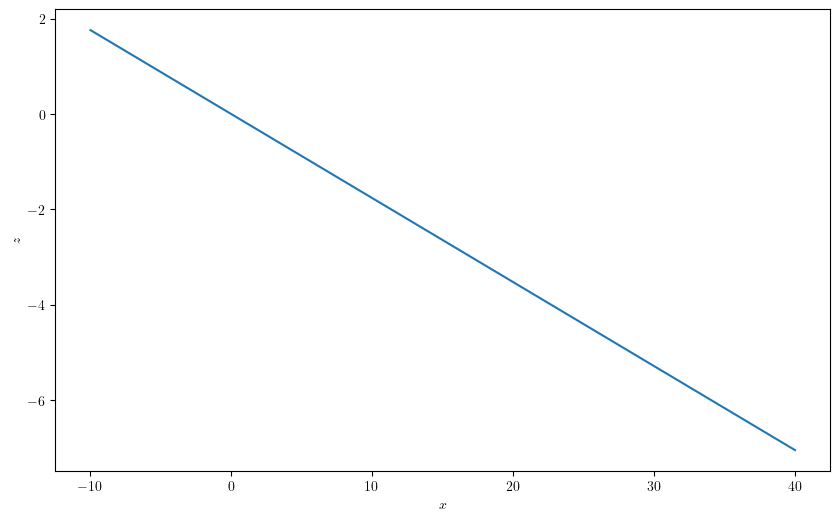

In [7]:
fig, ax = plt.subplots(figsize=(10,6))
 
ax.plot(topo_data.x, topo_data.z )
#ax.legend(loc='right')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$z$')

## Exporting parameters

In [8]:
parameters  = {'domain':domain,'computation':computation, 'rheology':rheology}

file_name = 'geoclaw_parameters.yaml'
with open(file_name, 'w') as file:
    yaml.dump(parameters, file)

print("Data has been written to "+file_name)

Data has been written to geoclaw_parameters.yaml


# Running geoclaw

In [9]:
make_output(parameters,verbosity=False)

I will make an AVAC computation.
Times: from t = 0 to t = 5 s with a time step dt = 0.05 s.


Makefile:76: avertissement : surchargement de la recette pour la cible « all »
/home/ancey/clawpack_git/clawpack/clawutil/src/Makefile.common:323: avertissement : ancienne recette ignorée pour la cible « all »


rm -f xgeo                           bc1.f.html out1.f.html  b4step1.f90.html myfunctions.f90.html qinit.f90.html setprob.f90.html src1.f90.html  module_avac.py.html setrun.py.html bouss.data.html claw.data.html dtopo.data.html gauges.data.html geoclaw.data.html grid.data.html setprob.data.html topo.data.html topography.data.html   Makefile.html
rm -f .data .output .plots .htmls 
Computation is successful.


# Plotting solution

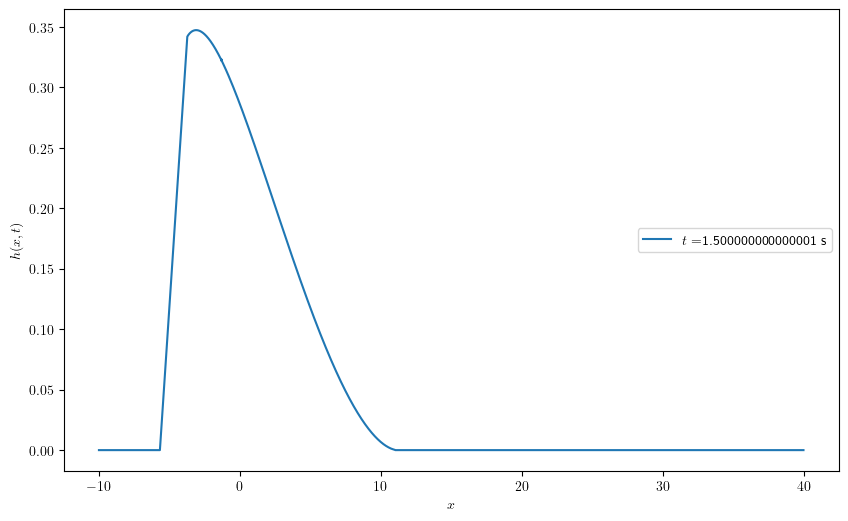

In [10]:
frameNo = 30
framesoln = solution.Solution(frameNo,  path=dirAddress,file_format='ascii')

x=framesoln.state.grid.x.centers
h=framesoln.state.q[0]
tt = framesoln.t
 
 

 
#true = qtrue(x,t)
fig, ax = plt.subplots(figsize=(10,6))
 
ax.plot(x, h,  label=r'$ t = $'+str(framesoln.t)+" s")
 
ax.legend(loc='right')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$h(x, t)$');

# Creating animation

In [11]:
# Animation for depth 

NbSim = computation['nb_simul']


## Flow depth on the sloping bed

In [12]:
# Animation for depth 
def dambreak_animation():
    sol=solution.Solution(1, path=dirAddress, file_format='ascii')
    frame = np.empty((NbSim,)+sol.state.q.shape)
    xsol = np.empty((NbSim, sol.state.q.shape[1]))
    hsol = np.empty((NbSim, sol.state.q.shape[1]))
    tps  = np.empty(NbSim)
    s    = sol.state.aux[0]

    for i in range(0,NbSim):
        sol     = solution.Solution(i, path=dirAddress, file_format='ascii')
        tps[i]  = sol.t
        xsol[i] = sol.state.grid.x.centers
        hsol[i] = sol.state.q[0]+s

    hmin = -1
    hmax = 3
    L = max(xsol[0])
    x0 = min(xsol[0])
    
    x_true = np.linspace(x0, L , 500)
    
    fig, axes = plt.subplots(figsize=(12, 4))
    
    plt.rcParams['text.usetex'] = True
    axes.set_xlabel(r'$x$',fontsize=14)
    axes.set_ylabel(r'$h(x, t)$',fontsize=14)
    axes.set_xlim((x_true[0], x_true[-1]))
    #axes.set_ylim(( hmin, hmax))
    axes.set_title(" ")
    text = axes.text(L/2, 2005.0 , '')
 
    def init():
        computed_line, = axes.plot(xsol[0][0], hsol[0][0], 'r')
        #exact_line, = axes.plot(x_true[0], 0 , 'k--')
        exact_line, = axes.plot(xsol[0], s , 'brown')
        axes.plot(xsol[0] , hsol[0] , '--')
        return  (computed_line, exact_line)
    
    computed_line, exact_line = init()
 
    def fplot(n):
        tt = tps[n]
 
        computed_line.set_data(xsol[n] ,  hsol[n] )
        tt = tps[n]
        val = f'{tt:.2f}'
        text.set_text(r'$ t = {} $ s'.format(val))
         
        return (computed_line, exact_line)

    frames_to_plot = range(0, NbSim)
    plt.close(fig)
    return matplotlib.animation.FuncAnimation(fig, fplot, frames=frames_to_plot, interval=100,
                                   blit=True, init_func=None, repeat=False)


from IPython.display import HTML 
anim = dambreak_animation( )
HTML(anim.to_jshtml()) 

2025-06-07 10:38:03,729 INFO CLAW: Animation.save using <class 'matplotlib.animation.HTMLWriter'>


## flow depth with the bottom set to horizontal

In [13]:

def dambreak_animation_h():
    sol=solution.Solution(1, path=dirAddress, file_format='ascii')
    frame = np.empty((NbSim,)+sol.state.q.shape)
    xsol = np.empty((NbSim, sol.state.q.shape[1]))
    hsol = np.empty((NbSim, sol.state.q.shape[1]))
    tps  = np.empty(NbSim)
    s    = sol.state.aux[0]

    for i in range(0,NbSim):
        sol     = solution.Solution(i, path=dirAddress, file_format='ascii')
        tps[i]  = sol.t
        xsol[i] = sol.state.grid.x.centers
        hsol[i] = sol.state.q[0] 

    hmin = 0
    hmax = np.max(hsol[0])
    L  = max(xsol[0])
    x0 = min(xsol[0])
    
    x_true = np.linspace(x0, L , 500)
    
    fig = plt.figure()
    axes = plt.subplot(1, 1, 1)
    plt.rcParams['text.usetex'] = True
    axes.set_xlabel(r'$x$',fontsize=14)
    axes.set_ylabel(r'$h(x, t)$',fontsize=14)
    axes.set_xlim((x[0], x[-1]))
    axes.set_ylim(( hmin, hmax))
    axes.set_title(" ")
    text = axes.text(L/2, 0.9*hmax , '')
 
    def init():
        computed_line, = axes.plot(xsol[0][0], hsol[0][0], 'r')
         
        #exact_line, = axes.plot(xsol[0], np.zeros_like(xsol[0]) , 'brown')
        exact_line, = axes.plot(xsol[0], hsol[0]  , '--')
        return  (computed_line, exact_line)
    
    computed_line, exact_line = init()
 
    def fplot(n):
        tt = tps[n]
        # if tt>0:
        #     htrue=(2*c0-x_true/tt)**2/9/g  \
        #      *np.where((x_true < 2*c0*tt) & (-c0*tt<x_true), 1, 0)+np.where(x_true < -c0*tt  , 1,0)
        # else:
        #     htrue= np.where(x_true < 0 , 1,0)
        computed_line.set_data(xsol[n] ,  hsol[n] )
        tt = tps[n]
        val = f'{tt:.2f}'
        text.set_text(r'$ t = {} $ s'.format(val))
         
        return (computed_line, exact_line)

    frames_to_plot = range(0, NbSim)
    plt.close(fig)
    return matplotlib.animation.FuncAnimation(fig, fplot, frames=frames_to_plot, interval=100,
                                   blit=True, init_func=None, repeat=False)


from IPython.display import HTML 
anim = dambreak_animation_h( )
HTML(anim.to_jshtml()) 

2025-06-07 10:38:15,321 INFO CLAW: Animation.save using <class 'matplotlib.animation.HTMLWriter'>


## Determing the front and back points

In [14]:
θ   = 10*np.pi/180
μ   = rheology['mu']
g   = rheology['gravity']
h_0 = 1
H0  = h_0
X0  = h_0
U0  = np.sqrt(g*H0*np.cos(θ))
T0  = np.sqrt(H0/np.cos(θ)/g)
#xb  = -40#-H0/np.tan(θ) 

sol   = solution.Solution(1, path=dirAddress, file_format='ascii')
frame = np.empty((NbSim,)+sol.state.q.shape)
xsol = np.empty((NbSim, sol.state.q.shape[1]))
hsol = np.empty((NbSim, sol.state.q.shape[1]))
qsol = np.empty((NbSim, sol.state.q.shape[1]))
usol = np.empty((NbSim, sol.state.q.shape[1]))
Hs   = np.empty((NbSim, sol.state.q.shape[1]))
HsDx = np.empty((NbSim, sol.state.q.shape[1]))
tps  = np.empty(NbSim)
dx   = (sol.domain.grid.x.upper-sol.domain.grid.x.lower)/sol.domain.grid.x.num_cells

for i in range(0,NbSim):
    sol     = solution.Solution(i, path=dirAddress, file_format='ascii')
    tps[i]  = sol.t
    xsol[i] = sol.state.grid.x.centers
    hsol[i] = sol.state.q[0]
    qsol[i] = sol.state.q[1]
    usol[i] = np.where(hsol[i]>0.,1/(1e-10+hsol[i]),0.)*qsol[i]
    Hs[i]   = hsol[i]*np.cos(θ)+usol[i]**2/2/g
    HsDx[i] = np.sin(θ)-np.insert(np.diff(Hs[i]) ,0,0)/dx

Text(0, 0.5, '$x_b$ (m)')

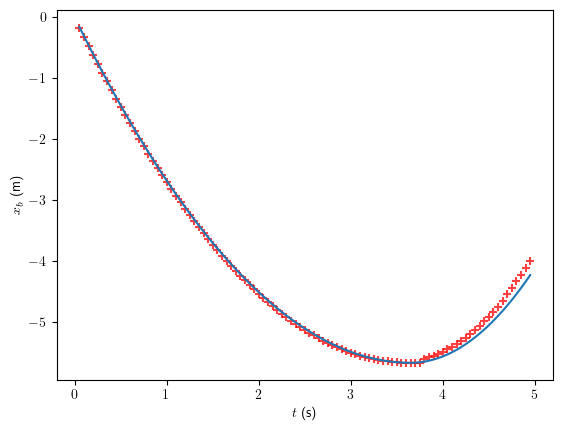

In [15]:
x_front = []
h_back = []
x_back  = []
ϵ = 1e-5
ϵ2 = 1e-4
for i in range(1,NbSim):
    posf2 = xsol[i][(usol[i]>ϵ)&( xsol[i]<0.)][0]
    posf1 = xsol[i][(usol[i]>ϵ2) &(hsol[i]>ϵ2)][0]
    posf  = max(posf1,posf2)
    hf   = hsol[i][xsol[i] ==posf]
    x_back.append(posf)
    h_back.append(hf)
    posf = np.max(xsol[i][usol[i] >0.0001])
    x_front.append(posf)

x_back = np.array(x_back)
x_front = np.array(x_front)
 
def sol_A(t):
    """ front position """
    return 2*t+np.tan(θ)* t**2/2


def sol_B(t):
    """ back front position """
    tb = 2/np.tan(θ)
    return np.where(t < tb, 
                   -t + (t**2/4)*np.tan(θ), 
                   -2*t + (t**2/2)*np.tan(θ) + 1/np.tan(θ))

fig = plt.figure()
axes = plt.subplot(1, 1, 1)
axes.scatter(tps[1:NbSim] ,x_back ,marker='+',color='red',alpha=0.75)
axes.plot(tps[1:NbSim],sol_B(tps[1:NbSim]/T0)*H0,'-')
axes.set_xlabel(r'$t$ (s)')
axes.set_ylabel(r'$x_b$ (m)')

Text(0, 0.5, '$x_f$ (m)')

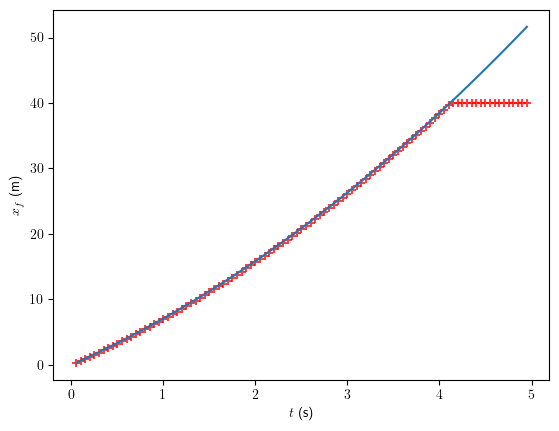

In [16]:
fig = plt.figure()
axes = plt.subplot(1, 1, 1)
axes.scatter(tps[1:NbSim] ,x_front ,marker='+',color='red',alpha=0.75)
axes.plot(tps[1:NbSim],sol_A(tps[1:NbSim]/T0)*H0,'-')
axes.set_xlabel(r'$t$ (s)')
axes.set_ylabel(r'$x_f$ (m)')

# Characteristics

In [17]:
# Interpolating functions
from scipy.interpolate import RegularGridInterpolator
hmat = np.array([hsol[i] for i in range(NbSim)])
umat = np.array([usol[i] for i in range(NbSim)])

interp_h = RegularGridInterpolator((xsol[0], tps ), hmat.T, bounds_error=False, fill_value=0.0)
interp_u = RegularGridInterpolator((xsol[0], tps ), umat.T, bounds_error=False, fill_value=0.0)

def fnc_h(x,t):
    return interp_h([x,t])[0]

def fnc_u(x,t):
    return interp_u([x,t])[0]




## Characteristic diagram with physical units

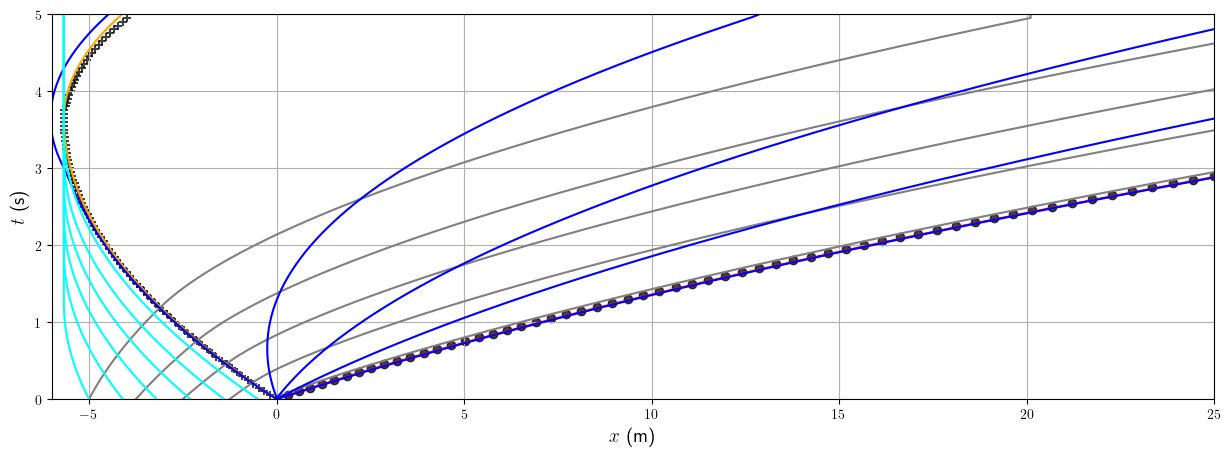

In [18]:
from scipy.integrate import solve_ivp, odeint
# Define the ODE system
def charac_r(x, t):
    """compute the r-characteristic"""
    # x must be a scalar for interpolation
    x = x.item() if np.size(x) == 1 else x           # scalar extraction
    point = np.array([[x, t]])                       # point (x,t). Note that shape is (1,2)
    dxdt = interp_u(point)+(g*interp_h(point))**0.5  # Interpolate
    return dxdt[0]   

def charac_s(x, t):
    """compute the s-characteristic"""
    x = x.item() if np.size(x) == 1 else x   
    point = np.array([[x, t]])   
    dxdt = interp_u(point)-(g*interp_h(point))**0.5  
    return dxdt[0]   

def charac_s_variante(x, t, s, theta, g):
    """
    compute the s-characteristic. In the variant, we use the fact that
    u-2c = s + t tan(theta) => u = 2c+s+t tan(theta)
    """
    x     = x.item() if np.size(x) == 1 else x   
    point = np.array([[x, t]])  #  
    u     = interp_u(point)
    h     = interp_h(point)
    if h<0: h=0.
    dxdt  = np.sqrt(g*h*np.cos(theta)) +t*np.sin(theta)*g+s*np.sqrt(g*H0*np.cos(theta))
    return dxdt

def test_xb(t, θ):
    tb = 2/np.tan(θ)
    return np.where(t < tb, 
                   -t + (t**2/4)*np.tan(θ), 
                   -2*t + (t**2/2)*np.tan(θ) + 1/np.tan(θ))

def test_xf(t,θ):
    return  2 *t+t**2/2*np.tan(θ)



fig, axes = plt.subplots(figsize=(15, 5))
plt.rcParams['text.usetex'] = True
axes.set_xlabel(r'$x$ (m)',fontsize=14)
axes.set_ylabel(r'$t$ (s)',fontsize=14)
axes.set_xlim((-6,25))
axes.set_ylim((0,5))
 
 
# Time range
t = np.arange(0.0, 5, 0.01)
t_eps = 1e-4
t2    = np.arange(t_eps, 5, 0.01)
axes.plot( H0*test_xf(t/T0,θ),t,color='red')   # front position
axes.plot(H0*test_xb(t/T0,θ),t,color='orange')  # backward wave
axes.grid()

# r-characteristic
for x0 in np.linspace(-5,0,5):
    # Solve the ODE using odeint
    result = odeint(charac_r,x0, t)
    axes.plot( result.flatten(),t,color='grey')  # r-characteristics
 
# s-characteristic in the rarefaction fan
for ss in np.linspace(-2, 2 , 5):
    result = odeint(charac_s_variante, y0=t_eps*ss*np.sqrt(g*H0*np.cos(θ)), t=t2, args=(ss,θ,g))
    #result = odeint(charac_s, y0=0.001*(2+3*ss)/4 * np.sqrt(g*H0*np.cos(θ)), t=t2 )
    plt.plot( result.flatten(),t2,color='blue')   

axes.scatter(x_back,tps[1:NbSim],marker='+',color='black',alpha=0.75) # measured back front
axes.scatter(x_front,tps[1:NbSim],marker='o',color='black',alpha=0.75) # measured back front
 
for x0 in np.linspace(-5,-0.5,6):
    # Solve the ODE using odeint
    result = odeint(charac_s,x0, t)
    axes.plot( result.flatten(),t,color='cyan')  # Flatten to 1D for plotting
 

In [19]:
fig.savefig('characteristics_physical-units.png',dpi=300, bbox_inches='tight')

## Dimensionless characteristic diagram  

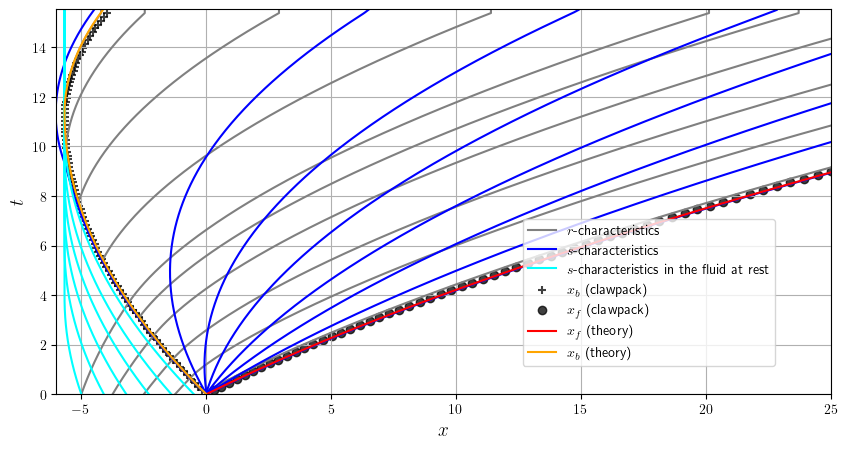

In [22]:
fig, axes = plt.subplots(figsize=(10, 5))
plt.rcParams['text.usetex'] = True
axes.set_xlabel(r'$x$',fontsize=14)
axes.set_ylabel(r'$t$',fontsize=14)
axes.set_xlim((-6/H0,25/H0))
axes.set_ylim((0,5/T0))
 
 
# Time range
t = np.arange(0.0, 5, 0.01)
t_eps = 1e-4
t2    = np.arange(t_eps, 5, 0.01)

axes.grid()

# r-characteristic
for x0 in np.linspace(-5,0,5):
    # Solve the ODE using odeint
    result = odeint(charac_r,x0, t)
    if x0 == -5:
        axes.plot( result.flatten()/H0,t/T0,color='grey',label=r'$r$-characteristics ')  # r-characteristics
    else:
        axes.plot( result.flatten()/H0,t/T0,color='grey' )

for tt in np.linspace(1.,4,5):
    xx = test_xb(tt/T0,θ)*H0
    t3 = np.arange(tt,5.5,0.01)
    result = odeint(charac_r,xx, t3)
    axes.plot( result.flatten()/H0,t3/T0,color='grey' )
 
# s-characteristic in the rarefaction fan
for ss in np.linspace(-2, 2 , 8):
    result = odeint(charac_s_variante, y0=t_eps*ss*np.sqrt(g*H0*np.cos(θ)), t=t2, args=(ss,θ,g))
    #result = odeint(charac_s, y0=0.001*(2+3*ss)/4 * np.sqrt(g*H0*np.cos(θ)), t=t2 )
    if ss == -2:
        plt.plot( result.flatten()/H0,t2/T0,color='blue',label=r'$s$-characteristics ')   
    else:
        plt.plot( result.flatten()/H0,t2/T0,color='blue' )  


# s-characteristic for the fluid at rest
for x0 in np.linspace(-5,-0.5,6):
    # Solve the ODE using odeint
    result = odeint(charac_s,x0, t)
    if x0 == -5:
        axes.plot( result.flatten()/H0,t/T0,color='cyan',label=r'$s$-characteristics in the fluid at rest')   
    else:
        axes.plot( result.flatten()/H0,t/T0,color='cyan' )

# moving boundaries (clawpack + theory)
axes.scatter(x_back/H0, tps[1:NbSim]/T0,marker='+',color='black',alpha=0.75,label=r'$x_b$ (clawpack)') # measured back front
axes.scatter(x_front/H0,tps[1:NbSim]/T0,marker='o',color='black',alpha=0.75,label=r'$x_f$ (clawpack) ') # measured back front

axes.plot(test_xf(t/T0,θ),t/T0,color='red',label=r'$x_f$ (theory) ')    # front position
axes.plot(test_xb(t/T0,θ),t/T0,color='orange',label=r'$x_b$ (theory) ')  # backward wave
fig.legend(loc='lower right',  ncol=1, borderaxespad=6)

In [70]:
fig.savefig('characteristics_dimensionless.png',dpi=300, bbox_inches='tight')

# Analytical solution

In [ ]:
from scipy.special import hyp2f1
from scipy.integrate import quad, dblquad
from functools import lru_cache
from scipy.optimize import root
from tqdm import tqdm
 
# ================== CORE FUNCTIONS (OPTIMIZED) ==================
@lru_cache(maxsize=None)  # Cache for repeated calls
def Riemann(r, s, x, y):
    """Optimized Riemann function with safeguards."""
    denominator = (r - y)**1.5 * (x - s)**1.5
    if denominator == 0:
        return 0.0
    c = (r - s)**3 / denominator
    z = ((r - x) * (y - s)) / ((-s + x) * (r - y))
    if np.isnan(z) or abs(z) >= 1.0:  # hyp2f1 convergence condition
        return 0.0
    return c * hyp2f1(1.5, 1.5, 1, z)

@lru_cache(maxsize=None)  # Cache for repeated calls
def XSRiemann(rr, ss, θ, eps=1e-4, limit=1000):
    """Optimized XSRiemann with proper integrand definition."""
    # Compute c1 term
    def TRiemann_integrand(x):
        return Riemann(x, -2, rr, ss) * (2 - 5*x) / (4 * (x + 2))
    
    c1 = (3*ss + rr) * quad(
        TRiemann_integrand, 2 + eps, rr,
        limit=limit, epsabs=1e-5, epsrel=1e-5)[0] / (4 * np.tan(θ))
    

    # Compute c2 term with properly scoped integrand
    def c2_integrand(x, r):
        return Riemann(x, -2, r, ss) * (2 - 5*x) / (4 * (x + 2)) * (x > r)
    
    c2, _ = dblquad(
        c2_integrand,
        rr, 2 - eps,  # r limits
        lambda r: max(2 + eps, r), lambda r: rr,  # x limits
        epsabs=1e-5, epsrel=1e-5)
    
    return c1 + c2 / (4 * np.tan(θ))

# ================== POSITION FUNCTION (VECTORIZED) ==================
def position(r, s, θ):
    """Vectorizable position function with all edge cases."""
    if s == -2:
        return 1/16 * (-2 + r) * (8 + (-2 + r) * np.tan(θ))
    elif (r == s) and (s > -2):
        return 0.0
    elif (r < -2) or (r >= 2):
        return np.nan
    elif s > r:
        return 0.0
    elif (-2 < s < r < 2):
        return XSRiemann(r, s, θ)
    else:
        return 0.0

# Vectorized version for array inputs
vposition = np.vectorize(position, excluded=['θ'])

def TRiemann(r, s, θ, eps=1e-4, limit=1000):
    """Compute the T-Riemann integral with singularity handling."""
    def integrand(x):
        return Riemann(x, -2, r, s) * (2 - 5*x) / (4 * (x + 2))
    
    # Handle potential singularities at integration bounds
    result, _ = quad(integrand, 2 + eps, r, 
                    limit=limit, 
                    points=[2 + eps, r],
                    epsabs=1e-6, 
                    epsrel=1e-6)
    return np.real(result) / np.tan(θ)


def temps(r, s, θ):
    if not np.isscalar(r):
        r = r.item()  # Extract scalar if r is a 0D array
    if (s > -2) and (s < r) and (r < 2) and (r > -2):
        return TRiemann(r, s, θ)
    else:
        return 0


In [170]:



tps = np.linspace(1, 5, 5)/T0
ϵ = 1e-2
s_min, s_max = -2 + ϵ, 2 - ϵ
recap_x, recap_u, recap_h = [], [], []

def solve_r(ss, tt, θ):
    sol = root(lambda r: temps(r, ss, θ) - tt, x0=(ss + 2)/2, method='lm')
    return sol.x[0] if sol.success else np.nan  # Ensure scalar output

for tt in tqdm(tps):
    s_values = np.linspace(s_min, s_max, 40)
    r_values = np.array([solve_r(ss, tt, θ) for ss in s_values])  # Convert to 1D array
    
    # Filter out solutions with NaN
    valid = ~np.isnan(r_values)
    s_values = s_values[valid]
    r_values = r_values[valid]
    
    solutions_x = [position(r, s, θ) + tt**2/2 * np.tan(θ) for r, s in zip(r_values, s_values)]
    solutions_u = (s_values + r_values)/2 + tt * np.tan(θ)
    solutions_h = (r_values - s_values)**2 / 16
    
    # Append boundary points
    solutions_x = np.append(solutions_x, 2*tt + tt**2/2 * np.tan(θ))
    solutions_u = np.append(solutions_u, 2 + tt * np.tan(θ))
    solutions_h = np.append(solutions_h, 0)
    
    if tt > 2/np.tan(θ):
        solutions_x = np.insert(solutions_x, 0, -2*tt + tt**2/2 * np.tan(θ) + 1/np.tan(θ))
        solutions_u = np.insert(solutions_u, 0, -2 + tt * np.tan(θ))
        solutions_h = np.insert(solutions_h, 0, 0)
    
    recap_x.append(solutions_x)
    recap_u.append(solutions_u)
    recap_h.append(solutions_h)

  0%|          | 0/5 [00:00<?, ?it/s]/home/ancey/anaconda3/envs/python3.12/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
 60%|██████    | 3/5 [01:27<01:04, 32.43s/it]/home/ancey/anaconda3/envs/python3.12/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = qua

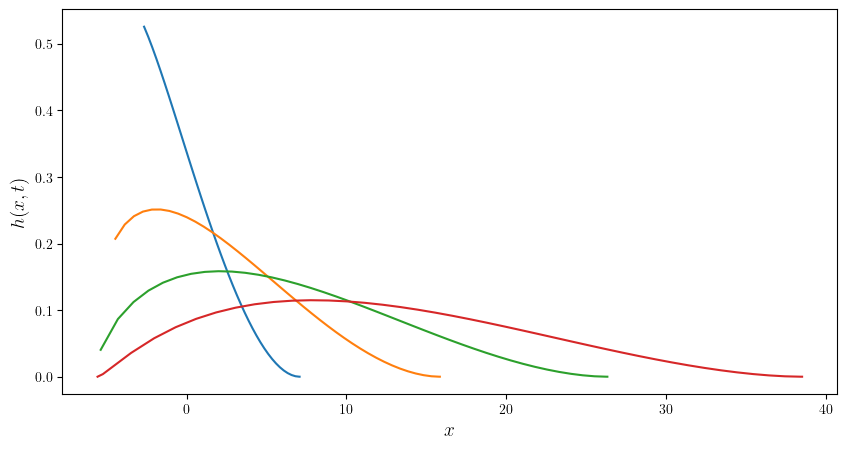

In [172]:
fig, axes = plt.subplots(figsize=(10, 5))
plt.rcParams['text.usetex'] = True
axes.set_xlabel(r'$x$',fontsize=14)
axes.set_ylabel(r'$h(x,t)$',fontsize=14)
# axes.set_xlim((-6/H0,25/H0))
# axes.set_ylim((0,5/T0))
for i in range(4):
    plt.plot(recap_x[i],recap_h[i])
 

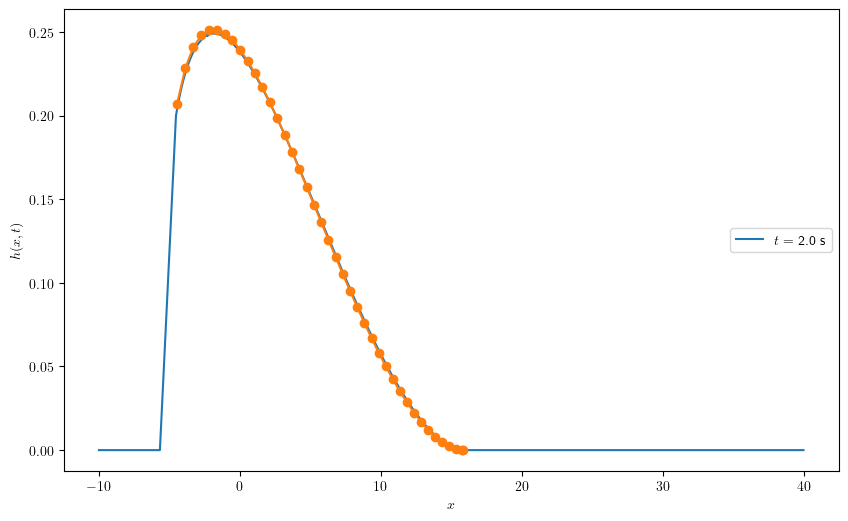

In [184]:
frameNo = 40
framesoln = solution.Solution(frameNo,  path=dirAddress,file_format='ascii')

x=framesoln.state.grid.x.centers
h=framesoln.state.q[0]
tt = framesoln.t
 
 

 
#true = qtrue(x,t)
fig, ax = plt.subplots(figsize=(10,6))
 
ax.plot(x/H0, h/H0,  label=r'$ t = $'+f" {framesoln.t:.1f} s")
 
ax.legend(loc='right')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$h(x, t)$')
plt.plot(recap_x[1],recap_h[1],marker='o')

Text(0, 0.5, '$h(x, t)$')

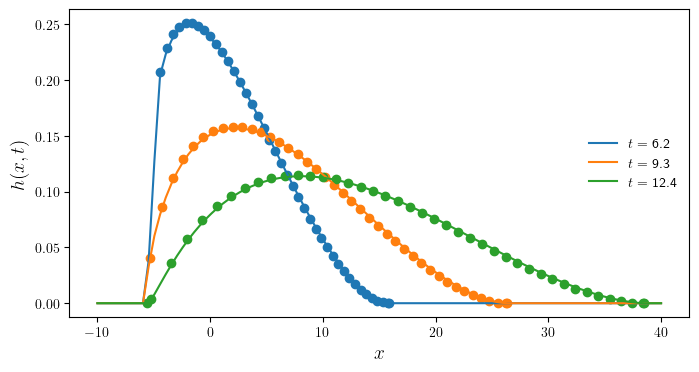

In [205]:
fig, ax = plt.subplots(figsize=(8,4))
x = np.linspace(-10,40,100)
ax.plot(x/H0, [ interp_h(np.array([[xx, 2]]) )/H0 for xx in x],  label=r'$ t = $'+f" {2/T0:.1f}")
ax.scatter(recap_x[1],recap_h[1],marker='o')

ax.plot(x/H0, [ interp_h(np.array([[xx, 3]]) )/H0 for xx in x],  label=r'$ t = $'+f" {3/T0:.1f}")
ax.scatter(recap_x[2],recap_h[2],marker='o')

ax.plot(x/H0, [ interp_h(np.array([[xx, 4]]) )/H0 for xx in x],  label=r'$ t = $'+f" {4/T0:.1f}")
ax.scatter(recap_x[3],recap_h[3],marker='o')



ax.legend(loc='right',frameon=False)
ax.set_xlabel(r'$x$',fontsize = 14)
ax.set_ylabel(r'$h(x, t)$',fontsize = 14)


In [206]:
fig.savefig('flow-depth_dimensionless.png',dpi=300, bbox_inches='tight')